<a href="https://colab.research.google.com/github/xiyichen/smplify-x-partial/blob/master/Keypoints_Blending_with_Confidence_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook allows you to perform keypoints blending and visualization for [OpenPose BODY_25 format model](https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html#pose-output-format-body_25) and [MMPose Halpe format model](https://mmpose.readthedocs.io/en/latest/topics/wholebody.html#halpe-dataset)

# Dependencies

In [ ]:
%cd /content
from google.colab import drive
drive.mount('/content/gdrive')
import os
from os.path import exists, join, basename, splitext
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import json
from collections import namedtuple

/content
Mounted at /content/gdrive


# Install OpenPose

In [ ]:
# @title Install OpenPose
# @markdown This will take some time (~10 mins). The code is taken from this [OpenPose Colab notebook](https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb).
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  # download models
  !wget -O /content/openpose/models/hand/pose_iter_102000.caffemodel https://polybox.ethz.ch/index.php/s/Oim76cuqrDVbdxm/download
  !wget -O /content/openpose/models/pose/body_25/pose_iter_584000.caffemodel https://polybox.ethz.ch/index.php/s/m5NQAhd7ukVPRoL/download
  !wget -O /content/openpose/models/face/pose_iter_116000.caffemodel https://polybox.ethz.ch/index.php/s/cEaF1FTpKjjJZbH/download
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

--2022-09-24 11:50:39--  https://polybox.ethz.ch/index.php/s/Oim76cuqrDVbdxm/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147344024 (141M) [application/octet-stream]
Saving to: ‘/content/openpose/models/hand/pose_iter_102000.caffemodel’

/content/openpose/m 100%[===================>] 140.52M  55.1MB/s    in 2.5s    

2022-09-24 11:50:42 (55.1 MB/s) - ‘/content/openpose/models/hand/pose_iter_102000.caffemodel’ saved [147344024/147344024]

--2022-09-24 11:50:42--  https://polybox.ethz.ch/index.php/s/m5NQAhd7ukVPRoL/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104715850 (100M) [application/octet-stream]
Saving to: ‘/content/openpose/models/pose/body_25/pose_iter_584000

# Install MMPose and download Halpe format model

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
%pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
%pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

# install mmdet for inference demo
%pip install mmdet

# clone mmpose repo
%rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose

# install mmpose dependencies
%pip install -r requirements.txt

# install mmpose in develop mode
%pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.3 MB/s eta 0:16:39tcmalloc: large alloc 1147494400 bytes == 0x38fda000 @  0x7f333e768615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |███████████████▉                | 1055.7 MB 1.3 MB/s eta 0:14:22tcmalloc: large alloc 1434370048 bytes == 0x7d630000 @  0x7f333e768615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |█████

In [ ]:
%cd /content/mmpose
import cv2
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True

pose_config = 'configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/halpe/hrnet_w48_halpe_384x288_dark_plus.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_halpe_384x288_dark_plus-d13c2588_20211021.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

/content/mmpose
load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_halpe_384x288_dark_plus-d13c2588_20211021.pth


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_halpe_384x288_dark_plus-d13c2588_20211021.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48_halpe_384x288_dark_plus-d13c2588_20211021.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


Downloading: "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth" to /root/.cache/torch/hub/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# Helper functions

In [ ]:
import mmcv
import math
def imshow_keypoints_modified(img,
                     pose_result,
                     skeleton=None,
                     kpts_score_thr=[0.3] * 136,
                     pose_kpt_color=None,
                     pose_link_color=None,
                     radius=4,
                     thickness=1,
                     show_keypoint_weight=False):
    img = mmcv.imread(img)
    img_h, img_w, _ = img.shape

    for kpts in pose_result:

        kpts = np.array(kpts, copy=False)

        # draw each point on image
        if pose_kpt_color is not None:
            assert len(pose_kpt_color) == len(kpts)

            for kid, kpt in enumerate(kpts):
                x_coord, y_coord, kpt_score = int(kpt[0]), int(kpt[1]), kpt[2]
                if kpt_score < kpts_score_thr[kid] or pose_kpt_color[kid] is None:
                    # skip the point that should not be drawn
                    continue

                color = tuple(int(c) for c in pose_kpt_color[kid])
                if show_keypoint_weight:
                    img_copy = img.copy()
                    cv2.circle(img_copy, (int(x_coord), int(y_coord)), radius,
                               color, -1)
                    transparency = max(0, min(1, kpt_score))
                    cv2.addWeighted(
                        img_copy,
                        transparency,
                        img,
                        1 - transparency,
                        0,
                        dst=img)
                else:
                    cv2.circle(img, (int(x_coord), int(y_coord)), radius,
                               color, -1)

        # draw links
        if skeleton is not None and pose_link_color is not None:
            assert len(pose_link_color) == len(skeleton)

            for sk_id, sk in enumerate(skeleton):
                pos1 = (int(kpts[sk[0], 0]), int(kpts[sk[0], 1]))
                pos2 = (int(kpts[sk[1], 0]), int(kpts[sk[1], 1]))

                if (pos1[0] <= 0 or pos1[0] >= img_w or pos1[1] <= 0
                        or pos1[1] >= img_h or pos2[0] <= 0 or pos2[0] >= img_w
                        or pos2[1] <= 0 or pos2[1] >= img_h
                        or kpts[sk[0], 2] < kpts_score_thr[sk[0]]
                        or kpts[sk[1], 2] < kpts_score_thr[sk[1]]
                        or pose_link_color[sk_id] is None):
                    # skip the link that should not be drawn
                    continue
                color = tuple(int(c) for c in pose_link_color[sk_id])
                if show_keypoint_weight:
                    img_copy = img.copy()
                    X = (pos1[0], pos2[0])
                    Y = (pos1[1], pos2[1])
                    mX = np.mean(X)
                    mY = np.mean(Y)
                    length = ((Y[0] - Y[1])**2 + (X[0] - X[1])**2)**0.5
                    angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
                    stickwidth = 2
                    polygon = cv2.ellipse2Poly(
                        (int(mX), int(mY)), (int(length / 2), int(stickwidth)),
                        int(angle), 0, 360, 1)
                    cv2.fillConvexPoly(img_copy, polygon, color)
                    transparency = max(
                        0, min(1, 0.5 * (kpts[sk[0], 2] + kpts[sk[1], 2])))
                    cv2.addWeighted(
                        img_copy,
                        transparency,
                        img,
                        1 - transparency,
                        0,
                        dst=img)
                else:
                    cv2.line(img, pos1, pos2, color, thickness=thickness)

    return 

In [ ]:
from mmcv.visualization.image import imshow
from mmcv.image import imwrite
from mmpose.core import imshow_bboxes
def show_result_modified(img,
                    result,
                    skeleton=None,
                    kpt_score_thr=0.3,
                    bbox_color='green',
                    pose_kpt_color=None,
                    pose_link_color=None,
                    text_color='white',
                    radius=4,
                    thickness=1,
                    font_scale=0.5,
                    bbox_thickness=1,
                    win_name='',
                    show=False,
                    show_keypoint_weight=False,
                    wait_time=0,
                    out_file=None):

        img = mmcv.imread(img)
        img = img.copy()

        bbox_result = []
        bbox_labels = []
        pose_result = []
        for res in result:
            if 'bbox' in res:
                bbox_result.append(res['bbox'])
                bbox_labels.append(res.get('label', None))
            pose_result.append(res['keypoints'])

        if bbox_result:
            bboxes = np.vstack(bbox_result)
            # draw bounding boxes
            imshow_bboxes(
                img,
                bboxes,
                labels=bbox_labels,
                colors=bbox_color,
                text_color=text_color,
                thickness=bbox_thickness,
                font_scale=font_scale,
                show=False)

        if pose_result:
            imshow_keypoints_modified(img, pose_result, skeleton, kpt_score_thr,
                             pose_kpt_color, pose_link_color, radius,
                             thickness)

        if show:
            imshow(img, win_name, wait_time)

        if out_file is not None:
            imwrite(img, out_file)

        return img

In [ ]:
def vis_pose_result_body_25(model,
                    img,
                    result,
                    radius=4,
                    thickness=1,
                    kpt_score_thr=0.3,
                    bbox_color='green',
                    dataset='TopDownCocoDataset',
                    dataset_info=None,
                    show=False,
                    out_file=None):
    """Visualize the detection results on the image.
    Args:
        model (nn.Module): The loaded detector.
        img (str | np.ndarray): Image filename or loaded image.
        result (list[dict]): The results to draw over `img`
                (bbox_result, pose_result).
        radius (int): Radius of circles.
        thickness (int): Thickness of lines.
        kpt_score_thr (float): The threshold to visualize the keypoints.
        skeleton (list[tuple()]): Default None.
        show (bool):  Whether to show the image. Default True.
        out_file (str|None): The filename of the output visualization image.
    """

    # get dataset info
    palette_body = np.array([[255, 0, 85], [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], [255, 0, 0],
        [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [255, 0, 170], [170, 0, 255], [255, 0, 255], [85, 0, 255],
        [0, 0, 255], [0, 0, 255], [0, 0, 255], [0, 255, 255], [0, 255, 255], [0, 255, 255]])
    body_skeleton = np.array([[1,8], [1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [8,9], [9,10], [10,11], 
    [8,12], [12,13], [13,14], [1,0], [0,15], [15,17], [0,16], [16,18], [14,19], [19,20], [14,21], [11,22], [22,23], [11,24]])
    body_link_color = palette_body[body_skeleton[:,1]]

    palette_hand = np.array([[100, 100, 100], [100, 0, 0], [150, 0, 0], [200, 0, 0], [255, 0, 0], [100, 100, 0], [150, 150, 0], [200, 200, 0], [255, 255, 0],
        [0, 100, 50], [0, 150, 75], [0, 200, 100], [0, 255, 125], [0, 50, 100], [0, 75, 150], [0, 100, 200], [0, 125, 255], [100, 0, 100], [150, 0, 150], [200, 0, 200], [255, 0, 255]])
    hand_skeleton = np.array([[0,1], [1,2], [2,3], [3,4], [0,5], [5,6], [6,7], [7,8], [0,9], [9,10], [10,11], [11,12], [0,13], [13,14], [14,15], [15,16], [0,17], [17,18], [18,19], [19,20]])
    hand_skeleton_left = hand_skeleton + 25
    hand_skeleton_right = hand_skeleton_left + 21
    hand_link_color = palette_hand[hand_skeleton[:,1]]
    pose_link_color = np.concatenate((body_link_color, hand_link_color, hand_link_color), axis=0)
    skeleton = np.concatenate((body_skeleton, hand_skeleton_left, hand_skeleton_right), axis=0)
    palette_face = np.array([[255, 255, 255]] * 68)
    pose_kpt_color = np.concatenate((palette_body, palette_hand, palette_hand, palette_face), axis=0)
    
    img = show_result_modified(
        img,
        result,
        skeleton,
        radius=radius,
        thickness=thickness,
        pose_kpt_color=pose_kpt_color,
        pose_link_color=pose_link_color,
        kpt_score_thr=kpt_score_thr,
        bbox_color=bbox_color,
        show=show,
        out_file=out_file)

    return img

In [ ]:
pose_model.show_result = show_result_modified

In [ ]:
Keypoints = namedtuple('Keypoints',
                       ['keypoints', 'gender_gt', 'gender_pd'])

Keypoints.__new__.__defaults__ = (None,) * len(Keypoints._fields)

def read_keypoints(keypoint_fn, use_hands=True, use_face=True,
                   use_face_contour=False, orders=['body', 'hands', 'face']):
    with open(keypoint_fn) as keypoint_file:
        data = json.load(keypoint_file)

    keypoints = []

    gender_pd = []
    gender_gt = []
    for idx, person_data in enumerate(data['people']):
        body_keypoints = np.array(person_data['pose_keypoints_2d'],
                                  dtype=np.float32)
        body_keypoints = body_keypoints.reshape([-1, 3])
        if use_hands:
            left_hand_keyp = np.array(
                person_data['hand_left_keypoints_2d'],
                dtype=np.float32).reshape([-1, 3])
            right_hand_keyp = np.array(
                person_data['hand_right_keypoints_2d'],
                dtype=np.float32).reshape([-1, 3])
            hands_keypoints = np.concatenate([left_hand_keyp, right_hand_keyp], axis=0)
        if use_face:
            face_keypoints = np.array(
                person_data['face_keypoints_2d'],
                dtype=np.float32).reshape([-1, 3])[:68, :]

        if orders[0] == 'body':
          curr_keypoints = body_keypoints
        elif orders[0] == 'hands':
          curr_keypoints = hands_keypoints
        else:
          curr_keypoints = face_keypoints
        
        if orders[1] == 'body':
          curr_keypoints = np.concatenate([curr_keypoints, body_keypoints])
        elif orders[1] == 'hands':
          curr_keypoints = np.concatenate([curr_keypoints, hands_keypoints])
        else:
          curr_keypoints = np.concatenate([curr_keypoints, face_keypoints])

        if orders[2] == 'body':
          curr_keypoints = np.concatenate([curr_keypoints, body_keypoints])
        elif orders[2] == 'hands':
          curr_keypoints = np.concatenate([curr_keypoints, hands_keypoints])
        else:
          curr_keypoints = np.concatenate([curr_keypoints, face_keypoints])

        keypoints.append(curr_keypoints)

    return keypoints[0]

# Upload images and set paths

In [ ]:
# @title Path of the .zip file of human images
IMAGES_ZIP_PATH = '/content/gdrive/MyDrive/cropped_EHF/images.zip' # @param {type:"string"}

IMAGES_ROOT = '/content/images'
!rm -r $IMAGES_ROOT
!mkdir $IMAGES_ROOT
!unzip -n $IMAGES_ZIP_PATH -d $IMAGES_ROOT
files = glob.glob(os.path.join(IMAGES_ROOT, '**/*.jpg')) + \
     glob.glob(os.path.join(IMAGES_ROOT, '**/*.jpeg')) + \
     glob.glob(os.path.join(IMAGES_ROOT, '**/*.png'))
if files == []:
  print('No images found')
else:
  IMAGES_PATH = '/' + os.path.join(*(files[0].split('/')[:-1]))

# Blending

In [ ]:
%cd /content
!rm -r openpose_results
!rm -r mmpose_results
!rm -r blending_results

/content


In [ ]:
# Run OpenPose
OPENPOSE_RES_DIR = '/content/openpose_results'
!mkdir $OPENPOSE_RES_DIR

!cd /content/openpose && ./build/examples/openpose/openpose.bin --image_dir $IMAGES_PATH --write_json $OPENPOSE_RES_DIR --face --hand --display 0 --render_pose 0

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 31.600386 seconds.


In [ ]:
# Run MMPose
MMPOSE_RES_DIR = '/content/mmpose_results'
!mkdir $MMPOSE_RES_DIR

for fn in glob.glob(os.path.join(IMAGES_PATH, '*')):
  img_name = fn.split('/')[-1].split('.')[0]
  img = os.path.join(IMAGES_PATH, img_name + '.jpg')

  # inference detection
  mmdet_results = inference_detector(det_model, img)

  # extract person (COCO_ID=1) bounding boxes from the detection results
  person_results = process_mmdet_results(mmdet_results, cat_id=1)

  # inference pose
  pose_results, returned_outputs = inference_top_down_pose_model(pose_model,
                                                                img,
                                                                person_results,
                                                                format='xyxy',
                                                                dataset=pose_model.cfg.data.test.type)
  param_dict = {}
  param_dict['people'] = [{"person_id":[-1]}]
  keypoints_flatten = pose_results[0]['keypoints'].flatten().tolist()
  param_dict['people'][0]['pose_keypoints_2d'] = keypoints_flatten[:26*3]
  param_dict['people'][0]['face_keypoints_2d'] = keypoints_flatten[26*3:94*3]
  param_dict['people'][0]['hand_left_keypoints_2d'] = keypoints_flatten[94*3:115*3]
  param_dict['people'][0]['hand_right_keypoints_2d'] = keypoints_flatten[115*3:]
  with open(os.path.join(MMPOSE_RES_DIR, img_name + '_mmpose.json'), 'w') as outfile:
    json.dump(param_dict, outfile, indent=2)

In [ ]:
# Load keypoints
openpose_files = {}
mmpose_files = {}
for fn in glob.glob(os.path.join(IMAGES_PATH, '*')):
  img_name = fn.split('/')[-1].split('.')[0]
  openpose_fn = os.path.join(OPENPOSE_RES_DIR, img_name + '_keypoints.json')
  openpose_files[img_name] = read_keypoints(openpose_fn, use_hands=True, use_face=True, use_face_contour=True)
  mmpose_fn = os.path.join(MMPOSE_RES_DIR, img_name + '_mmpose.json')
  mmpose_files[img_name] = read_keypoints(mmpose_fn, use_hands=True, use_face=True, use_face_contour=True)

In [ ]:
# Matching keypoints for different formats
pairs = {"Nose": {'MMPose': 0, 'OpenPose': 0},
      "LEye": {'MMPose': 1, 'OpenPose': 16},
      "REye": {'MMPose': 2, 'OpenPose': 15},
      "LEar": {'MMPose': 3, 'OpenPose': 18},
      "REar": {'MMPose': 4, 'OpenPose': 17},
      "LShoulder": {'MMPose': 5, 'OpenPose': 5},
      "RShoulder": {'MMPose': 6, 'OpenPose': 2},
      "LElbow": {'MMPose': 7, 'OpenPose': 6},
      "RElbow": {'MMPose': 8, 'OpenPose': 3},
      "LWrist": {'MMPose': 9, 'OpenPose': 7},
      "RWrist": {'MMPose': 10, 'OpenPose': 4},
      "LHip": {'MMPose': 11, 'OpenPose': 12},
      "RHip": {'MMPose': 12, 'OpenPose': 9},
      "LKnee": {'MMPose': 13, 'OpenPose': 13},
      "RKnee": {'MMPose': 14, 'OpenPose': 10},
      "LAnkle": {'MMPose': 15, 'OpenPose': 14},
      "RAnkle": {'MMPose': 16, 'OpenPose': 11},
      # "Head": {'MMPose': 17}, omitted since no counterpart in OpenPose
      "Neck": {'MMPose': 18, 'OpenPose': 1},
      "Hip": {'MMPose': 19, 'OpenPose': 8},
      "LBigToe": {'MMPose': 20, 'OpenPose': 19},
      "RBigToe": {'MMPose': 21, 'OpenPose': 22},
      "LSmallToe": {'MMPose': 22, 'OpenPose': 20},
      "RSmallToe":{'MMPose': 23, 'OpenPose': 23},
      "LHeel": {'MMPose': 24, 'OpenPose': 21},
      "RHeel": {'MMPose': 25, 'OpenPose': 24}}

In [ ]:
openpose_pose_len = 25
mmpose_pose_len = 26
for i in range(21):
  key = 'left_hand_' + str(i+1)
  pairs[key] = {}
  pairs[key]['OpenPose'] = openpose_pose_len + i
  pairs[key]['MMPose'] = mmpose_pose_len + i
for i in range(21):
  key = 'right_hand_' + str(i+1)
  pairs[key] = {}
  pairs[key]['OpenPose'] = openpose_pose_len + 21 + i
  pairs[key]['MMPose'] = mmpose_pose_len + 21 + i
for i in range(68):
  key = 'face_' + str(i+1)
  pairs[key] = {}
  pairs[key]['OpenPose'] = openpose_pose_len + 42 + i
  pairs[key]['MMPose'] = mmpose_pose_len + 42 + i

In [ ]:
# Get the heuristics for per-keypoint statistics, used for confidence score calibration
!mkdir /content/heuristics
!wget -O /content/shhq_heuristics.zip https://polybox.ethz.ch/index.php/s/UHTisMSR5RzMi0X/download
!unzip -n /content/shhq_heuristics.zip -d /content/heuristics
with open('/content/heuristics/openpose_means.json', 'r') as f:
  openpose_means = json.load(f)
with open('/content/heuristics/openpose_stds.json', 'r') as f:
  openpose_stds = json.load(f)
with open('/content/heuristics/mmpose_means.json', 'r') as f:
  mmpose_means = json.load(f)
with open('/content/heuristics/mmpose_stds.json', 'r') as f:
  mmpose_stds = json.load(f)

mkdir: cannot create directory ‘/content/heuristics’: File exists
--2022-09-24 13:42:47--  https://polybox.ethz.ch/index.php/s/UHTisMSR5RzMi0X/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7526 (7.3K) [application/zip]
Saving to: ‘/content/shhq_heuristics.zip’

/content/shhq_heuri 100%[===================>]   7.35K  --.-KB/s    in 0s      

2022-09-24 13:42:47 (781 MB/s) - ‘/content/shhq_heuristics.zip’ saved [7526/7526]

Archive:  /content/shhq_heuristics.zip


In [ ]:
# Blending
BLENDING_RES_DIR = '/content/blending_results'
!mkdir $BLENDING_RES_DIR
for fn in glob.glob(os.path.join(IMAGES_PATH, '*')):
  img_name = fn.split('/')[-1].split('.')[0]
  blended_current = np.zeros((135, 3))
  for key in pairs:
    if 'face' in key:
      openpose_conf = openpose_files[img_name][pairs[key]['OpenPose']][2]
      openpose_conf = np.clip(openpose_conf, 0, 1)
      blended_current[pairs[key]['OpenPose']][0] = openpose_files[img_name][pairs[key]['OpenPose']][0]
      blended_current[pairs[key]['OpenPose']][1] = openpose_files[img_name][pairs[key]['OpenPose']][1]
      blended_current[pairs[key]['OpenPose']][2] = openpose_conf
    else:
      openpose_conf = -1
      if 'OpenPose' in pairs[key]:
        openpose_conf = openpose_files[img_name][pairs[key]['OpenPose']][2]
        openpose_conf = np.clip(openpose_conf, 0, 1)
      mmpose_conf = -1
      if 'MMPose' in pairs[key]:
        mmpose_conf = mmpose_files[img_name][pairs[key]['MMPose']][2]
        mmpose_conf = (mmpose_conf - mmpose_means[key]) / mmpose_stds[key]
        mmpose_conf = mmpose_conf * openpose_stds[key] + openpose_means[key]
        mmpose_conf = np.clip(mmpose_conf, 0, 1)
    
      if mmpose_conf > openpose_conf:
        blended_current[pairs[key]['OpenPose']][0] = mmpose_files[img_name][pairs[key]['MMPose']][0]
        blended_current[pairs[key]['OpenPose']][1] = mmpose_files[img_name][pairs[key]['MMPose']][1]
        blended_current[pairs[key]['OpenPose']][2] = mmpose_conf
      else:
        blended_current[pairs[key]['OpenPose']][0] = openpose_files[img_name][pairs[key]['OpenPose']][0]
        blended_current[pairs[key]['OpenPose']][1] = openpose_files[img_name][pairs[key]['OpenPose']][1]
        blended_current[pairs[key]['OpenPose']][2] = openpose_conf

  blended_current = blended_current.flatten().tolist()
  param_dict = {}
  param_dict['people'] = [{"person_id":[-1]}]
  param_dict['people'][0]['pose_keypoints_2d'] = blended_current[:25*3]
  param_dict['people'][0]['hand_left_keypoints_2d'] = blended_current[25*3:46*3]
  param_dict['people'][0]['hand_right_keypoints_2d'] = blended_current[46*3:67*3]
  param_dict['people'][0]['face_keypoints_2d'] = blended_current[67*3:]
  with open(os.path.join(BLENDING_RES_DIR, img_name + '_blended.json'), 'w') as outfile:
    json.dump(param_dict, outfile, indent=2)

In [ ]:
!zip /content/blending_results.zip /content/blending_results/*

updating: content/blending_results/01_cropped_blended.json (deflated 69%)
updating: content/blending_results/02_cropped_blended.json (deflated 73%)
updating: content/blending_results/03_cropped_blended.json (deflated 73%)
updating: content/blending_results/04_cropped_blended.json (deflated 71%)
updating: content/blending_results/05_cropped_blended.json (deflated 72%)
updating: content/blending_results/06_cropped_blended.json (deflated 72%)
updating: content/blending_results/07_cropped_blended.json (deflated 73%)
updating: content/blending_results/08_cropped_blended.json (deflated 72%)
updating: content/blending_results/09_cropped_blended.json (deflated 70%)
updating: content/blending_results/100_cropped_blended.json (deflated 70%)
updating: content/blending_results/10_cropped_blended.json (deflated 71%)
updating: content/blending_results/11_cropped_blended.json (deflated 70%)
updating: content/blending_results/12_cropped_blended.json (deflated 70%)
updating: content/blending_results/13

# Visualization (with thresholding on body keypoints)

Dropdown(description='Image:', options=('/content/images/images/01_cropped.jpg', '/content/images/images/02_cr…

OpenPose Keypoints


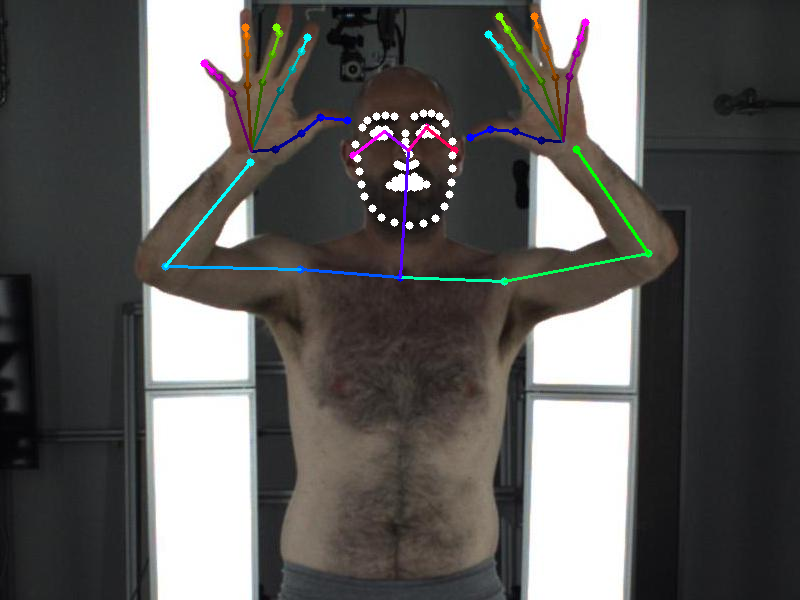

MMPose Keypoints


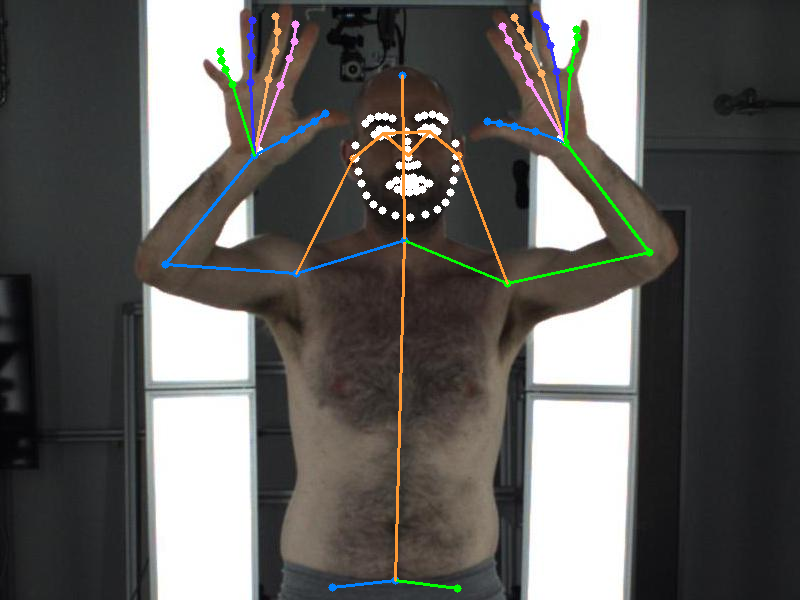

Blended Keypoints


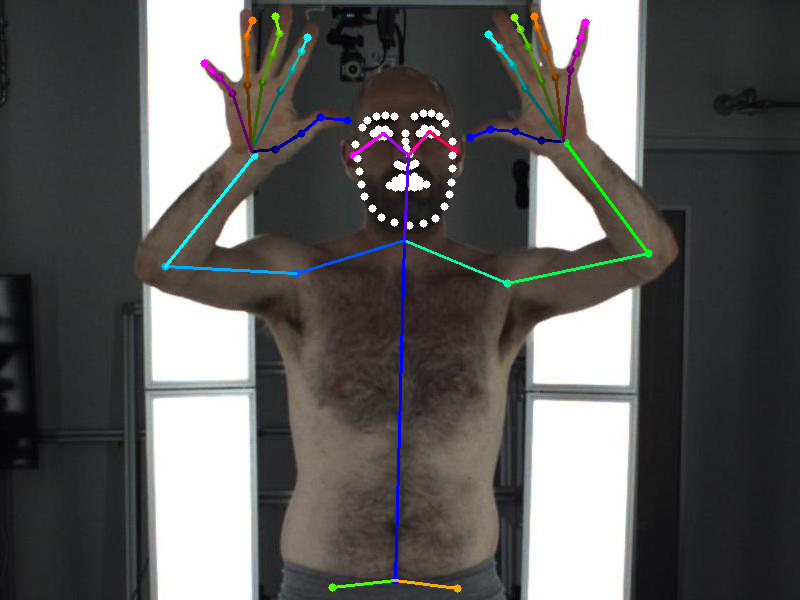

In [ ]:
#@title Select an image in the dropdown menu to visualize its keypoints. It takes a few seconds to render once an image is selected.
openpose_threshold = 0.2 # @param {type:"number"}
mmpose_threshold = 0.5 # @param {type:"number"}\
threshold_on = 'body_only' #@param ["body_only", "body+hands", "body+hands+face", "none"]

import ipywidgets as widgets
from IPython.display import display, clear_output
import glob
image_list = glob.glob(os.path.join(IMAGES_PATH, '*'))
image_list.sort()
w = widgets.Dropdown(
    options=image_list,
    value=None,
    description='Image:',
)

def on_change(change):
  try:
    new_index = change['new']['index']
    clear_output()
    display(w)
    curr_fn = image_list[new_index]
    img_name = curr_fn.split('/')[-1].split('.')[0]
    openpose_detections = read_keypoints(os.path.join(OPENPOSE_RES_DIR, img_name + '_keypoints.json'), True, True, True)
    vis_result_openpose = vis_pose_result_body_25(pose_model,
                                os.path.join(IMAGES_PATH, img_name + '.jpg'),
                                [{'keypoints': openpose_detections}],
                                kpt_score_thr=[openpose_threshold if 'body' in threshold_on else 0]*25 + 
                                [openpose_threshold if 'hands' in threshold_on else 0]*42 + 
                                [openpose_threshold if 'face' in threshold_on else 0]*68,
                                thickness=2,
                                show=False)
    mmpose_detections = read_keypoints(os.path.join(MMPOSE_RES_DIR, img_name + '_mmpose.json'), True, True, True, orders=['body', 'face', 'hands'])
    vis_results_mmpose = vis_pose_result(pose_model,
                                os.path.join(IMAGES_PATH, img_name + '.jpg'),
                                [{'keypoints': mmpose_detections}],
                                dataset=pose_model.cfg.data.test.type,
                                kpt_score_thr=[mmpose_threshold if 'body' in threshold_on else 0]*26 + 
                                [mmpose_threshold if 'hands' in threshold_on else 0]*42 + 
                                [mmpose_threshold if 'face' in threshold_on else 0]*68,
                                thickness=2,
                                show=False)
    blended_detections = read_keypoints(os.path.join(BLENDING_RES_DIR, img_name + '_blended.json'), True, True, True)
    vis_result_blended = vis_pose_result_body_25(pose_model, 
                                os.path.join(IMAGES_PATH, img_name + '.jpg'),
                                [{'keypoints': blended_detections}], 
                                thickness=2,
                                kpt_score_thr=[openpose_threshold if 'body' in threshold_on else 0]*25 + 
                                [openpose_threshold if 'hands' in threshold_on else 0]*42 + 
                                [openpose_threshold if 'face' in threshold_on else 0]*68,
                                show=False)
    print('OpenPose Keypoints')
    cv2_imshow(vis_result_openpose)
    print('MMPose Keypoints')
    cv2_imshow(vis_results_mmpose)
    print('Blended Keypoints')
    cv2_imshow(vis_result_blended)
  except:
    pass

w.observe(on_change)

display(w)